## Dataset information as per Kaggle (https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)

1. **train.csv** - The training set.
   * `Id` Unique identifier for each observation.
   * `AB-GL` Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
   * `Class` A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
2. **test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
3. **greeks.csv** - Supplemental metadata, only available for the training set.
   * `Alpha` Identifies the type of age-related condition, if present.
     * `A` No age-related condition. Corresponds to class 0.
     * `B`, `D`, `G` The three age-related conditions. Correspond to class 1.
   * `Beta`, `Gamma`, `Delta` Three experimental characteristics.
   * `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [1]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


# To-do for preprocessing

1. Class weights
2. Finalize hyperparameters
   1. n_neighbors
   2. num_features
   3. ~~Test % split~~ 80-20
3. kPCA vs PCA -> **Go with PCA** maybe ask Cornelia
   1. kPCA over PCA if the data is nonlinear, but what's the best way to determin linearity?

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf, keras, and sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# For hyperparameter tuning
import keras_tuner
from tensorflow import keras

# Unused atm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


from mlxtend.plotting import heatmap

# Stats library
import statsmodels.api as sm

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [3]:
greeks = pd.read_csv('../data/greeks.csv')
#test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

greeks.columns = map(str.lower, greeks.columns)
#test.columns = map(str.lower, test.columns)
train.columns = map(str.lower, train.columns)

print('Shape of greeks df:', greeks.shape)
#print('Shape of test df:', test.shape)
print('Shape of train df:', train.shape)

# Merge train and greeks to get all columns in the same DataFrame
df = pd.merge(train, greeks, on='id')

Shape of greeks df: (617, 6)
Shape of train df: (617, 58)


In [4]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

In [5]:
def feature_reduction(method, num_features, data_split):
    if method == 'pca':
        # Split into Train and Test
        X_train, X_test, Y_train, Y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(X_train)

        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)

        # PCA
        pca = PCA(n_components = num_features)
        pca.fit(X_train_std)
        X_train_pca = pd.DataFrame(pca.transform(X_train_std))
        X_test_pca = pd.DataFrame(pca.transform(X_test_std))

        return X_train_pca, X_test_pca, Y_train, Y_test
    
    elif method == 'tsne':
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(features_variable)
        features_variable_std = sc.transform(features_variable)

        tsne = TSNE(n_components=num_features, random_state=0, perplexity=50, n_iter=5000, method = 'exact')

        # Calculate the 12 features via tSNE model
        features_variable_tsne = pd.DataFrame(tsne.fit_transform(features_variable_std))

        #Split into Train and Test
        X_train, X_test, Y_train, Y_test = train_test_split(features_variable_tsne, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        return X_train, X_test, Y_train, Y_test


In [6]:
X_train, X_test, Y_train, Y_test = feature_reduction('pca', 23, 0.2)

In [7]:
display(X_train.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train.shape)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-0.690887,0.685788,1.006226,-1.171854,0.136816,0.093421,-0.481733,0.392191,-0.176123,-0.091700,...,0.595791,0.838373,-1.056261,0.535441,1.200978,-0.158611,-0.077590,-0.139836,-0.224102,-0.726805
1,-0.441772,0.454223,1.462607,-0.617965,-0.293618,0.023432,0.153689,-1.660740,-0.165092,0.878005,...,2.096800,0.786217,-1.216243,0.658438,0.838084,0.360564,-0.085385,-0.239045,-0.435239,-0.537305
2,0.671402,-1.941961,-1.723888,0.351624,0.629489,1.202796,1.880502,1.530765,-0.002930,0.937556,...,-0.159973,1.091466,0.823074,-0.526456,-0.124357,-0.583080,-0.040892,0.021261,1.472451,-0.945578
3,-1.129595,-1.193760,1.500116,-0.829614,0.123395,0.421081,1.446770,-1.168590,0.334539,0.943517,...,-0.940358,1.113140,-0.061908,-0.002122,-0.511413,0.160301,0.051340,-1.812252,0.043625,0.140780
4,-0.449661,0.533336,-2.227092,1.630291,-0.744035,-0.592698,0.645509,-0.155894,-1.008784,0.356228,...,-0.375001,-0.789424,0.171670,0.285349,0.590511,-0.380552,-0.343775,-0.816738,-0.552360,-0.553257


(617, 57)

(493, 23)

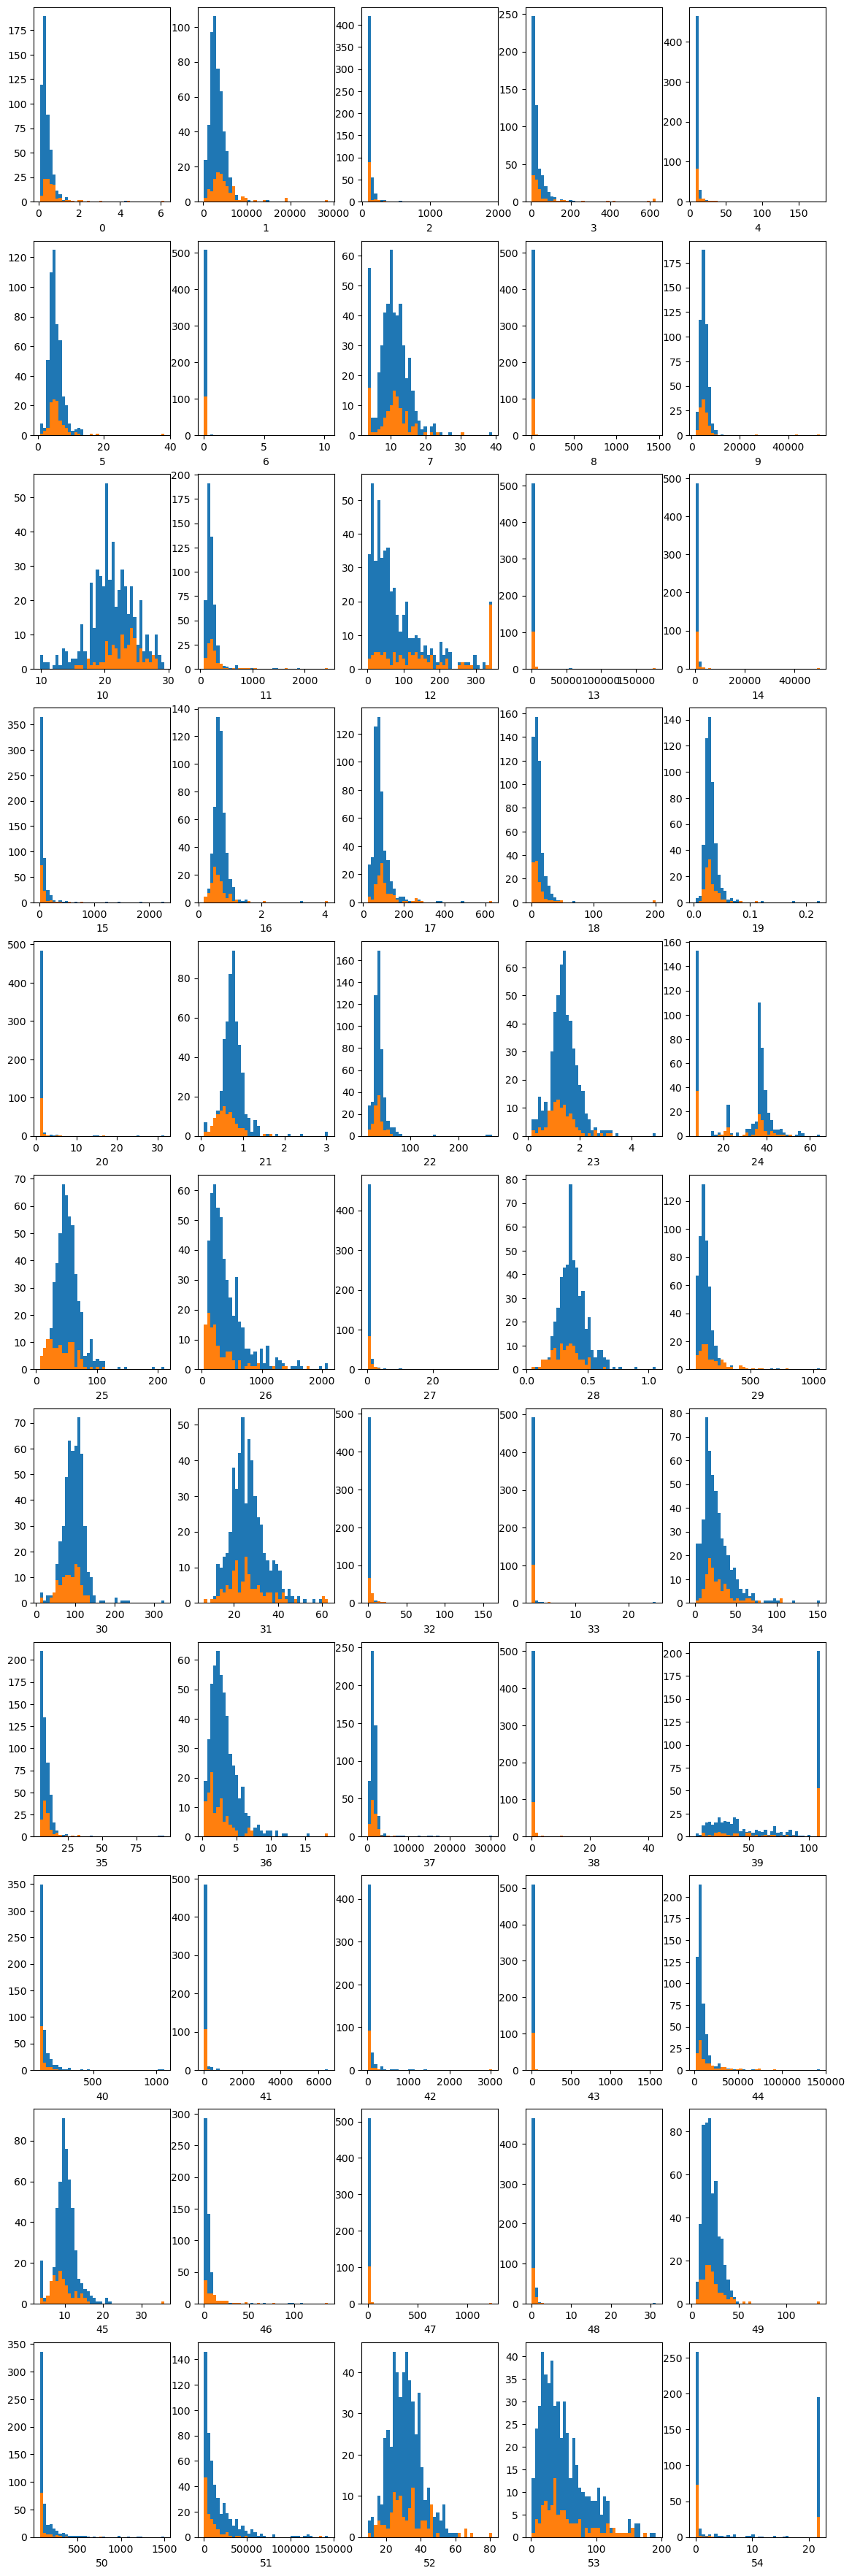

In [8]:
##########################################
### This is on 100% of the data, needs ###
### needs to be on split data.         ###
##########################################

df_train = pd.DataFrame(features_variable).join(target_variable)
columns = list(df_train.columns)
fig, axes = plt.subplots(nrows=11, ncols=5, figsize=(14,45))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    # if(columns[idx] in ['EJ','Beta','Gamma','Delta']):
    #     no_disease = df_train[df_train['Alpha']==0][columns[idx]]
    #     disease = df_train[df_train['Alpha']!=0][columns[idx]]
    #     ax.hist(no_disease)
    #     ax.hist(disease)
    # else:
    no_disease = df_train[df_train['class']==0][columns[idx]]
    disease = df_train[df_train['class']!=0][columns[idx]]
    bins=np.histogram(np.hstack((no_disease,disease)), bins=40)[1]
    ax.hist(no_disease, bins)
    ax.hist(disease, bins)
    # set xlabel
    ax.set_xlabel(columns[idx])

### Modelling

Build the Model

In [9]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                dropout_rate=0.1):
    
    """Build a binary-class logistic regression model using Keras.

    Args:
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model (graph).
    """
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Create hidden layers with dropout layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=layer_size,activation=activation))
        
        # Add dropout layer for regularization
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
    # Specify optimizer
    if optimizer == 'Adam':
        selected_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model

Run Experiments

In [10]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       dropout_rate=0.1,
                       num_epochs=5,
                       num_folds=10):

  # Address the class imbalances by using class weights.
  # Scaling by total/2 helps keep the loss to a similar magnitude.
  # The sum of the weights of all examples stays the same.
  weight_for_0 = (1 / Y_train.value_counts()[0]) * (Y_train.size / 2.0)
  weight_for_1 = (1 / Y_train.value_counts()[1]) * (Y_train.size / 2.0)
  class_weight = {0: weight_for_0, 1: weight_for_1}
    
  # Create a k-fold object with k subsets
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)

  # Create a list to hold the accuracy for each k-fold.
  accuracy_history = []
    
  # Iterate over the k subsets
  for train_index, test_index in kfold.split(X_train):
        X_train_k, X_test_k = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_k, Y_test_k = Y_train.iloc[train_index], Y_train.iloc[test_index]
 
        # Build the model.
        model = build_model(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate,
                      dropout_rate=dropout_rate)

        # Train the model.
        print('Training...')
        history = model.fit(
            x=X_train_k,                # our binary training examples
            y=Y_train_k,                # corresponding binary labels
            epochs=num_epochs,        # number of passes through the training data
            batch_size=32,            # mini-batch size for SGD
            validation_split=0.2,     # use a fraction of the examples for validation
            verbose=0,                # do not display progress output during training
            class_weight=class_weight # use the calculated class weights to address the imbalance
            )

        ######
        #
        # Do you run evaluate on (X_test, Y_test) or (X_test_k, Y_test_k)?
        #
        ######
        
        # Calculate the accuracy of the model
        test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['binary_accuracy']

        print(f'Accuracy: {test_accuracy}')
        
        # Add the accuracy to the history list
        accuracy_history.append(test_accuracy)
        
        # Plot the loss and accuracy
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        ax1, ax2 = axes.ravel()

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax1.plot(train_loss, label='train_loss')
        ax1.plot(val_loss, label='validation loss')
        ax1.set_xticks(range(num_epochs))
        ax1.set_xlabel('Train epochs')
        ax1.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax1.legend()

        train_accuracy = history.history['binary_accuracy']
        val_accuracy = history.history['val_binary_accuracy']
        ax2.plot(train_accuracy, label='train_accuracy')
        ax2.plot(val_accuracy, label='validation accuracy')
        ax2.set_xticks(range(num_epochs))
        ax2.set_xlabel('Train epochs')
        ax2.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax2.legend()

        plt.show()
    
  # Print the model summary.
  print(model.summary())
    
  # Print the average accuracy of the k folds.
  print(f'Average Accuracy: {sum(accuracy_history) / len(accuracy_history)}')

Hyperparameter Tuning

In [25]:
def build_and_tune_model(hp):
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=5, max_value=100, step=5),
            activation=hp.Choice('activation', ['relu', 'tanh'])
            ))        
        
    # Choose whether to include a dropout layer and tune the dropout rate
    if hp.Boolean('dropout'):
        model.add(tf.keras.layers.Dropout(rate=(hp.Int('dropout_rate', min_value=10, max_value=50, step=5))*0.01))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))

    # For tuning the learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")              
                  
    # Specify optimizer

    # Only using Adam optimizer if using PCA.
    optimizer = 'Adam'
    
    if optimizer == 'Adam':
        selected_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model

# Tune the model
build_and_tune_model(keras_tuner.HyperParameters())

# Set up tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_and_tune_model,
    objective="val_loss",
    max_trials=500,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="ICR",
)

# Display the tuner search space
tuner.search_space_summary()

# Start tuning - Can specify the number of epochs here.
tuner.search(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

# Report tuning results
tuner.results_summary()

Trial 500 Complete [00h 00m 12s]
val_loss: 0.3372413416703542

Best val_loss So Far: 0.28769412636756897
Total elapsed time: 01h 41m 45s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\ICR
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 326 summary
Hyperparameters:
num_layers: 2
units_0: 95
activation: tanh
dropout: False
lr: 0.0018610333445099496
units_1: 10
dropout_rate: 25
units_2: 5
Score: 0.28769412636756897

Trial 447 summary
Hyperparameters:
num_layers: 2
units_0: 70
activation: tanh
dropout: True
lr: 0.003118525643862443
units_1: 5
dropout_rate: 10
units_2: 5
Score: 0.29320531090100604

Trial 106 summary
Hyperparameters:
num_layers: 2
units_0: 65
activation: tanh
dropout: False
lr: 0.0012584339358744161
units_1: 5
dropout_rate: 40
units_2: 10
Score: 0.3067135314146678

Trial 438 summary
Hyperparameters:
num_layers: 2
units_0: 95
activation: tanh
dropout: True
lr: 0.000661554082035594
units_1: 15
dropout_rate: 30
units_2: 45
Scor

In [27]:
# tuner.results_summary()


Training...
Accuracy: 0.8548387289047241


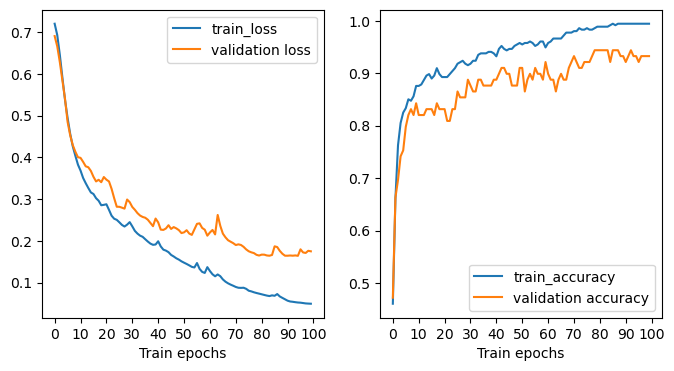

Training...
Accuracy: 0.8790322542190552


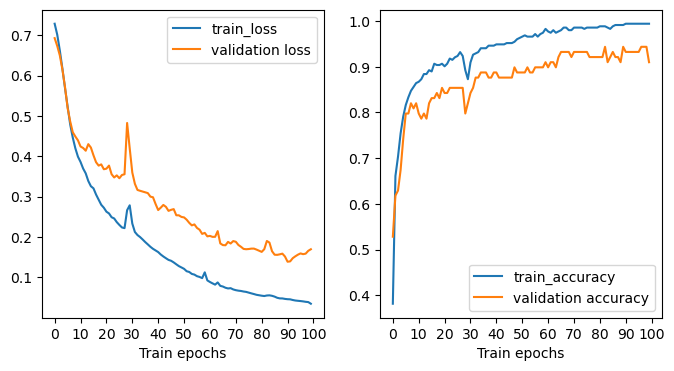

Training...
Accuracy: 0.8709677457809448


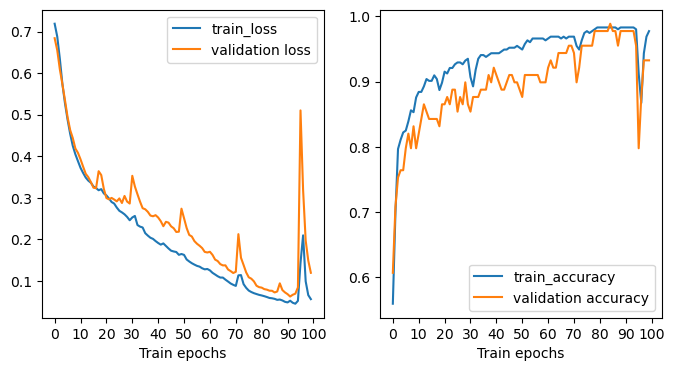

Training...
Accuracy: 0.8790322542190552


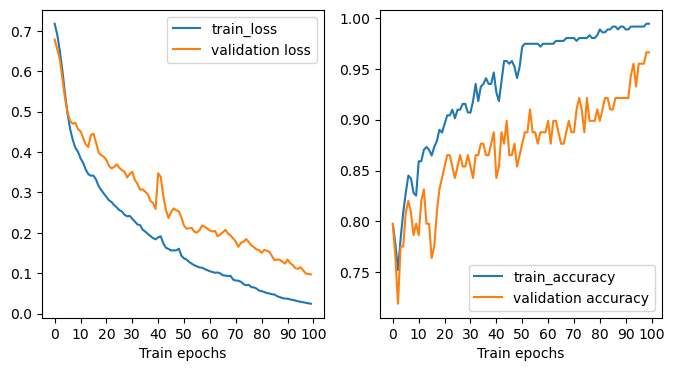

Training...
Accuracy: 0.9112903475761414


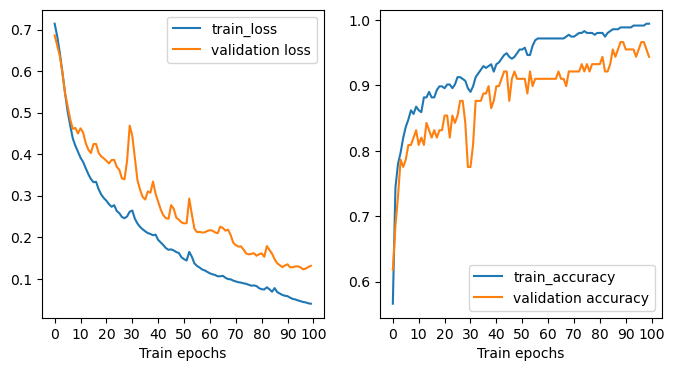

Training...
Accuracy: 0.8790322542190552


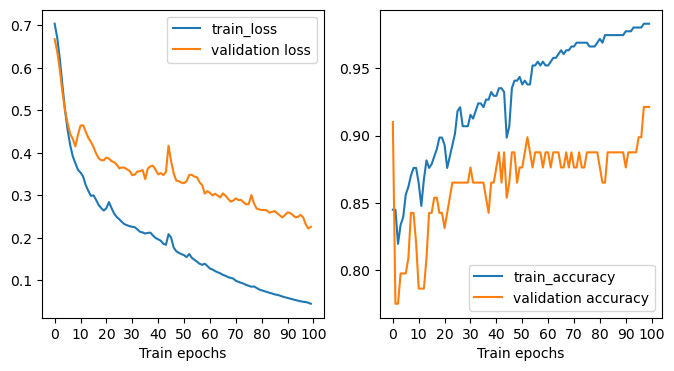

Training...
Accuracy: 0.8629032373428345


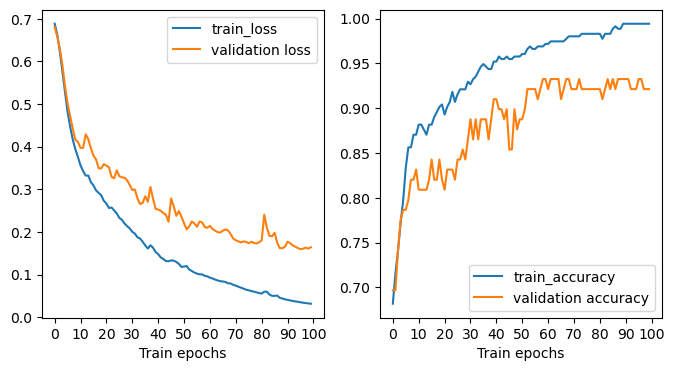

Training...
Accuracy: 0.8709677457809448


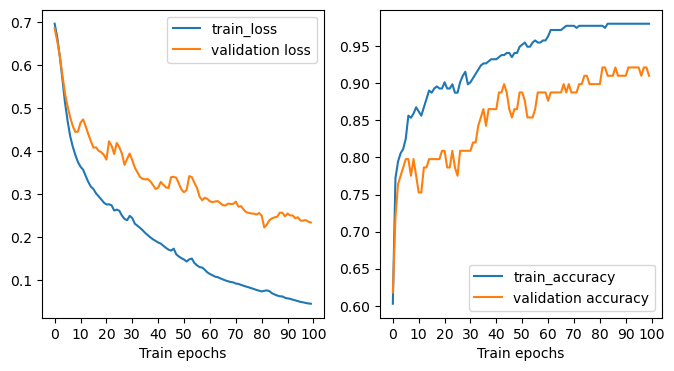

Training...
Accuracy: 0.8548387289047241


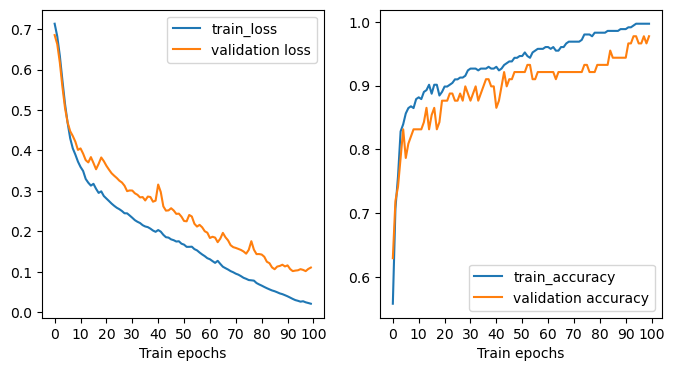

Training...
Accuracy: 0.8870967626571655


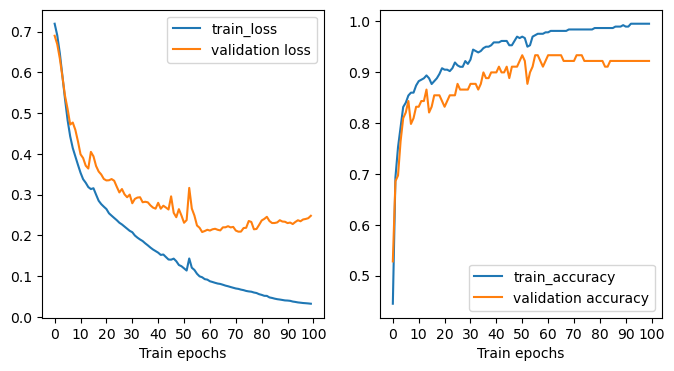

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2280      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,251
Trainable params: 3,251
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8750000059604645


In [28]:
train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0018610333445099496,
    dropout_rate=0.0,
    num_epochs=100,
    num_folds=10)

Training...
Accuracy: 0.8951612710952759


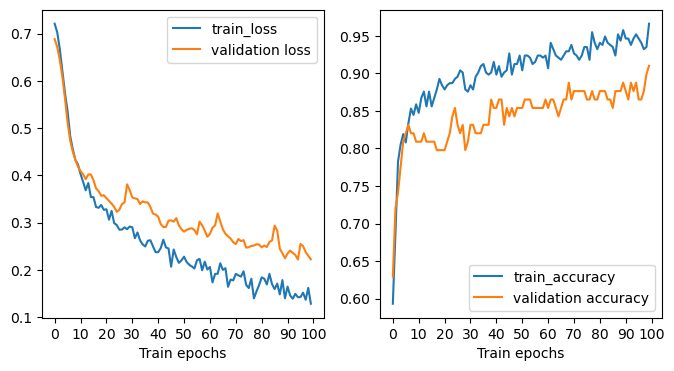

Training...
Accuracy: 0.9032257795333862


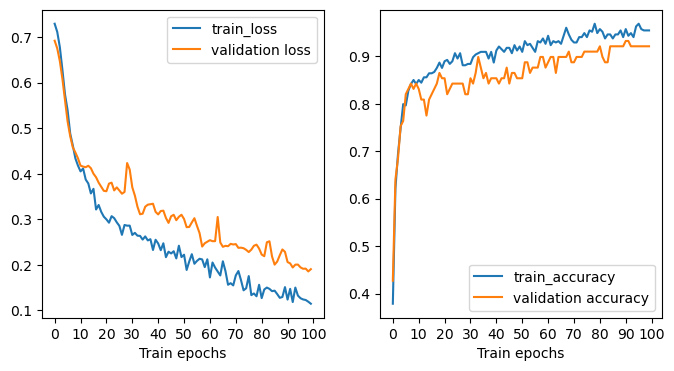

Training...
Accuracy: 0.8629032373428345


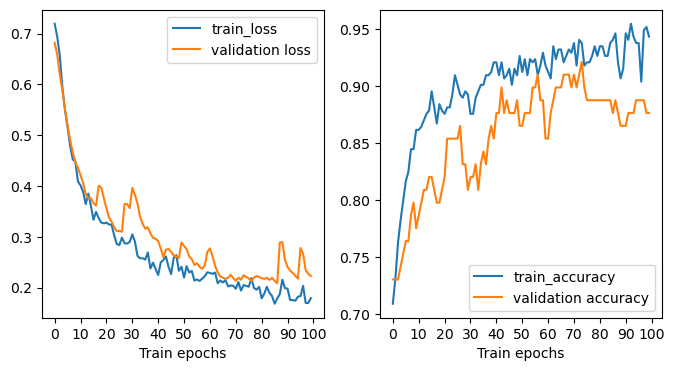

Training...
Accuracy: 0.8870967626571655


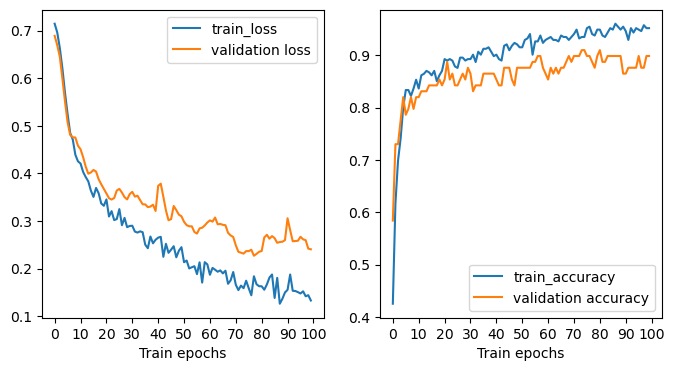

Training...
Accuracy: 0.8951612710952759


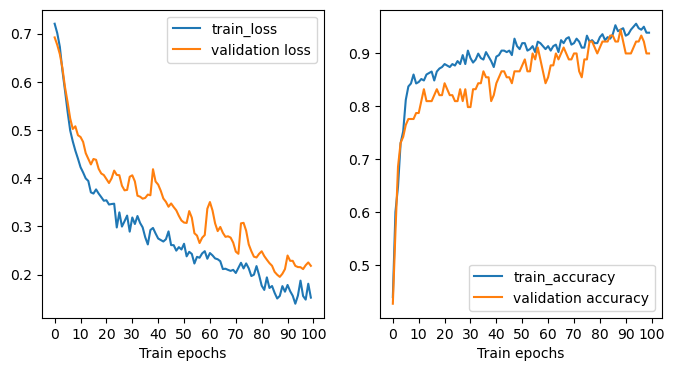

Training...
Accuracy: 0.8548387289047241


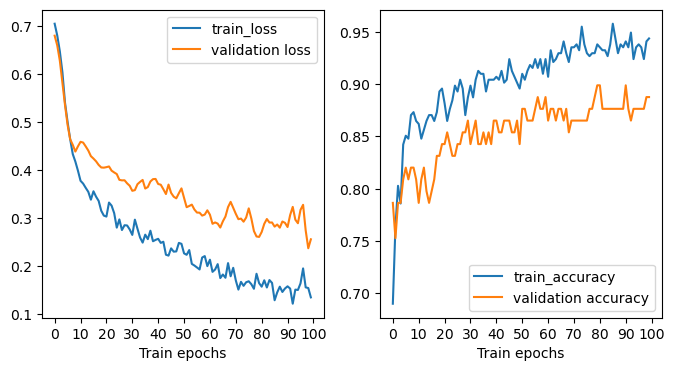

Training...
Accuracy: 0.8709677457809448


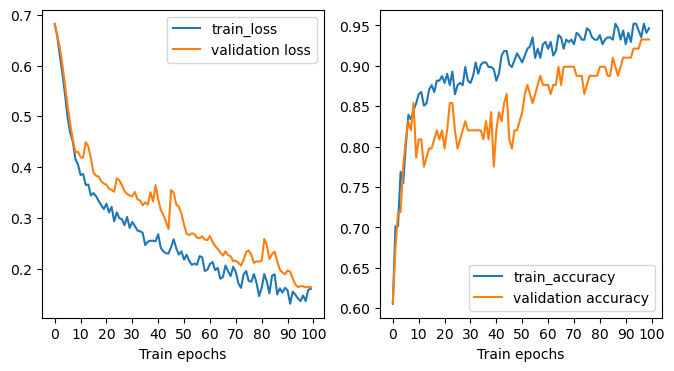

Training...
Accuracy: 0.8709677457809448


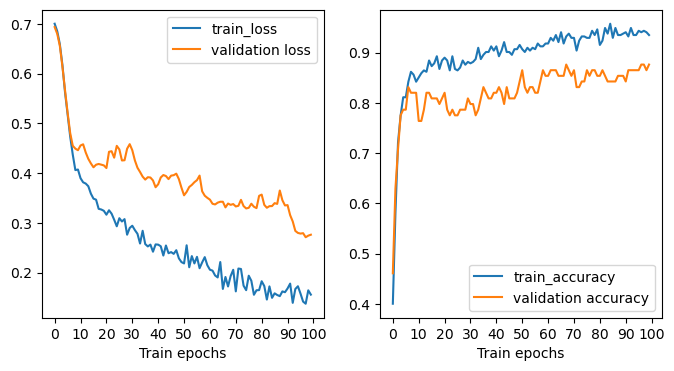

Training...
Accuracy: 0.8951612710952759


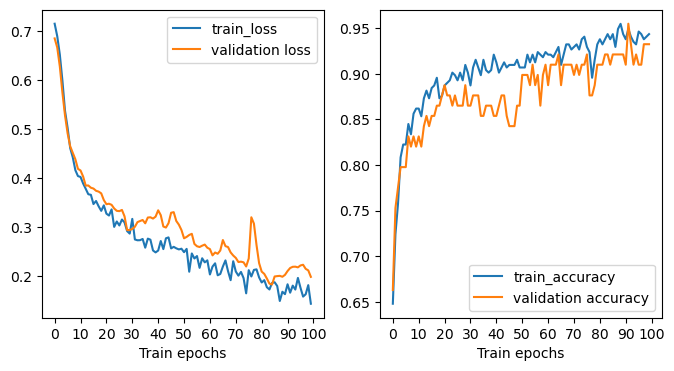

Training...
Accuracy: 0.8951612710952759


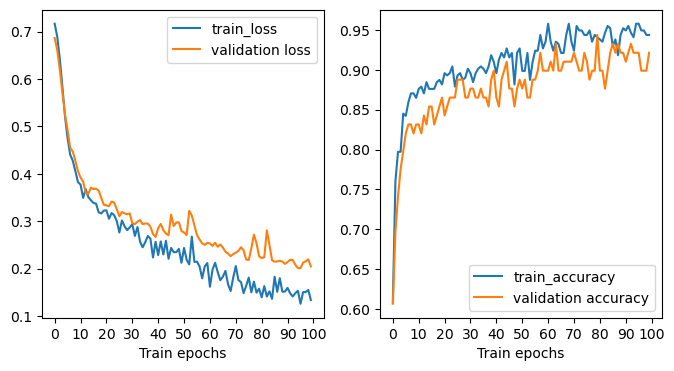

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2280      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,251
Trainable params: 3,251
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8830645084381104


In [29]:
train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0018610333445099496,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)